In [1]:
pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

C:\Users\Ahmed\AppData\Roaming\Python\Python38\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
### Prepare the data
num_classes = 10
input_shape = (32,32,3)

(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()

In [4]:
### configure hyperparameter

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 1
image_size = 72 # this is the image resize target size
patch_size = 6 # size of the patches to be extracted from input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 32
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 2
mlp_head_units = [512, 256]

In [5]:
### use data augmentation

data_augmentation = keras.Sequential(
    [
        # layers.Normalization(),
        layers.Resizing(image_size, image_size),
        # layers.RandomFlip('horizontal'),
        # layers.RandomRotation(factor=0.02),
        # layers.RandomZoom(
        #     height_factor=0.2, width_factor=0.2
        # ),
    ],
    name='data_augmentation'
)

#compute the mean and variance of the training data for normalization
# data_augmentation.layers[0].adapt(x_train)

In [6]:
### implement multilayer perceptron
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [7]:
### implement patch creation as a layer

class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size
  
  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images, 
        sizes=[1,self.patch_size, self.patch_size, 1],
        strides=[1,self.patch_size, self.patch_size, 1],
        rates=[1,1,1,1],
        padding='VALID'
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Patches shape: (1, 144, 108)
Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


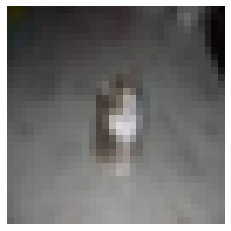

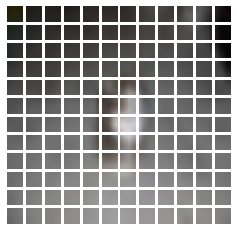

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)

print(f'Patches shape: {patches.shape}')
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n,n,i+1)
  patch_img = tf.reshape(patch, (patch_size,patch_size,3))
  plt.imshow(patch_img.numpy().astype("uint8"))
  plt.axis('off')

In [9]:
### Implement the patch encoding layer

class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches
    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [10]:
### Build the ViT model

def create_vit_clf():
  inputs = layers.Input(shape=input_shape)
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  #create multiple layers of the Transformer block
  for _ in range(transformer_layers):
    # layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # create a multi-head attention layer
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # skip connection 1
    x2 = layers.Add()([attention_output, encoded_patches])
    # layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # skip connection 2.
    encoded_patches = layers.Add()([x3, x2])

  # create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)

  # add mlp.
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  # classify outputs
  logits = layers.Dense(num_classes)(features)

  # create the keras model.
  model = keras.Model(inputs=inputs, outputs=logits)
  return model


In [11]:
### compile, train, and evaluate the model

def run_experiment(model):
  optimizer = tf.keras.optimizers.experimental.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  model.compile(
      optimizer=optimizer,
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
          keras.metrics.SparseTopKCategoricalAccuracy(5, name='top-5-accuracy'),
          keras.metrics.SparseCategoricalAccuracy(name='accuracy')
      ],
  )

  checkpoint_filepath='/checkpoint'
  checkpoint_callback = keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      monitor='val_accuracy',
      save_best_only = True,
      save_weights_only=True,
  )

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size = batch_size,
      epochs = num_epochs,
      validation_split = 0.1,
      callbacks = [checkpoint_callback],
    )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f'Test accuracy: {round(accuracy * 100,2)}%')
  print(f'Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%')

  return history



In [12]:
vit_clf = create_vit_clf()
# vit_clf.summary()
history = run_experiment(vit_clf)

  89/2813 [..............................] - ETA: 10:13 - loss: 3.5588 - top-5-accuracy: 0.5162 - accuracy: 0.1032

KeyboardInterrupt: 